Latex commands
$$
% Abbreviations
\newcommand{\rhs}[0]{right hand side}  % right hand side
\newcommand{\lhs}[0]{left hand side}  % left hand side
\newcommand{\snr}[0]{snr}  % signal-to-noise ratio
% Definitions
\newcommand{\realnumbers}[0]{\mathbb{R}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
% boldface symbols
\newcommand{\ab}[0]{\mathbf{a}}
\newcommand{\bb}[0]{\mathbf{b}}
\newcommand{\xb}[0]{\mathbf{x}}
\newcommand{\setx}[0]{\mathbf{x}_1,\ldots,\mathbf{x}_C}
\newcommand{\setxn}[0]{\mathbf{x}_1^{(n)},\ldots,\mathbf{x}_C^{(n)}}
\newcommand{\yb}[0]{\mathbf{y}}
\newcommand{\zb}[0]{\mathbf{z}}
\newcommand{\dz}[0]{d\zb}
% colored symbols
\newcommand{\xc}[0]{\color{blue}x\color{black}}
\newcommand{\xbc}[0]{\color{blue}\xb\color{black}}
\newcommand{\yc}[0]{\color{olive}y\color{black}}
\newcommand{\ybc}[0]{\color{olive}\yb\color{black}}
% normal symbols
\newcommand{\alphab}[0]{\boldsymbol{\alpha}}
\newcommand{\thetab}[0]{\boldsymbol{\theta}}
\newcommand{\thetaset}[0]{\thetab_1,\ldots,\thetab_C}
\newcommand{\phib}[0]{\boldsymbol{\phi}}
\newcommand{\phiset}[0]{\phib_1,\ldots,\phib_C}
\newcommand{\etab}[0]{\boldsymbol{\eta}}
\newcommand{\epsilonb}[0]{\boldsymbol{\epsilon}}
\newcommand{\x}[0]{\xb}
\newcommand{\z}[0]{\zb}
\newcommand{\Zcal}[0]{\mathcal{Z}}
\newcommand{\q}[1]{q\left(#1\right)}
\newcommand{\p}[1]{p\left(#1\right)}
\newcommand{\Lin}[0]{\mathbf{L}}
\newcommand{\mub}[0]{\boldsymbol{\mu}}
\newcommand{\Sigmab}[0]{\boldsymbol{\Sigma}}
\newcommand{\sigmab}[0]{\boldsymbol{\sigma}}
% Gaussian
\newcommand{\Gauss}[2]{\mathcal{N}\left(#1;#2\right)}
\newcommand{\Gaussof}[1]{\mathcal{N}\left(#1\right)}
\newcommand{\Gausstd}[0]{\Gauss{\mathbf{0}}{\mathbf{I}}}
\newcommand{\GaussStdDim}[1]{\Gauss{\mathbf{0}}{\mathbf{I}_{#1}}}
% Kullback-Leibler
\newcommand{\kl}[0]{\operatorname{\mathcal{D}_{KL}}}
\newcommand{\KL}[2]{\kl\bigg(#1\left|\right|#2\bigg)}
% Expected Value
\newcommand{\expect}{\operatorname{\mathbb{E}}}
\newcommand{\Var}{\operatorname{Var}}
\newcommand{\Cov}{\operatorname{Cov}}
\newcommand{\VAR}[1]{\Var\left[#1\right]}
\newcommand{\COV}[1]{\Cov\left[#1\right]}
\newcommand{\E}[1]{\expect\left[#1\right]}
\newcommand{\EE}[2]{\expect_{#1}\left[#2\right]}
% Variational approximation
\newcommand{\qz}[0]{\q{\z}}
\newcommand{\qzgx}[0]{\q{\z|\x}}
\newcommand{\qzgsetx}[0]{\q{\z|\setx}}
\newcommand{\qzg}[1]{\q{\z|#1}}
\newcommand{\qzx}[1]{\q{\z|\x_{#1}}}
% Marginal / Joint probabilities
\newcommand{\px}[0]{\p{\x}}
\newcommand{\pz}[0]{\p{\z}}
\newcommand{\pxz}[0]{\p{\x,\z}}
\newcommand{\psetx}[0]{\p{\setx}}
\newcommand{\psetxz}[0]{\p{\setx,\z}}
% Conditional probabilities
\newcommand{\pxgz}[0]{\p{\x|\z}} % x Given z
\newcommand{\psetxgz}[0]{\p{\setx|\z}}
\newcommand{\pzgsetx}[0]{\p{\z|\setx}}
\newcommand{\pzgx}[0]{\p{\z|\x}}
% Posterior
\newcommand{\pzsetx}[0]{\p{\z|\setx}}
% Lower Bound
\newcommand{\LB}[0]{\mathcal{L}\left(\thetab, \phib, \x \right)}
$$

In [4]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from mcvae import pytorch_modules, utilities, preprocessing, plot, diagnostics
from pathlib import Path

DEVICE = pytorch_modules.DEVICE
print(f"Running on {DEVICE}")

Running on cpu


### Data creation
We are going to create a multichannel dataset, according to the following generative scheme:

\begin{align}
&\z \sim \GaussStdDim{l}, \\
&\epsilonb \sim \GaussStdDim{d_c}, \\
&\mathbf{G}_c = diag\left( \mathbf{R}_c \mathbf{R}_c^T \right)^{-1/2} \mathbf{R}_c, \\
&\x_c = \mathbf{G}_c \z + \snr^{-1/2} \cdot \epsilonb,
\end{align}

Excercise:

where  for every channel $c$, $\mathbf{R}_c \in \realnumbers^{d_c \times l}$ is a random matrix with $l$ orthonormal columns (i.e. $\mathbf{R}_c^T \mathbf{R}_c = \mathbf{I}_l$), $\mathbf{G}_c$ is the linear generative law, and $\snr$ is the signal-to-noise ratio.

**Excercise**:
Verify that the diagonal elements of the covariance matrix of $\x_c$ are inversely proportional to $\snr$, i.e. that
$diag\left(\E{\x_c\x_c^T}\right) = (1 + \snr^{-1}) \mathbf{I}_{d_c}$.

The data generation method `pytorch_modules.ScenarioGenerator` creates a dataset according to the previous equations, with $\snr = +\infty$.

We are going to create a $3$-channel dataset $[\x_1, \x_2, \x_3]$ with $4$ features and $N=500$ observations for each channel ($\x_i \in \realnumbers^{N\times4}$)

We will create it by applying $3$ different linear transformations $\mathbf{G}_c$ to a common $2$-dimensional latent variable ($\mathbf{z} \in \realnumbers^{N\times2}$).

In [6]:
Nobs = 500
n_channels = 3
n_feats = 4
true_lat_dims = 2
fit_lat_dims = 5

np.random.seed(7)
z = np.random.randn(Nobs, true_lat_dims)
z_test = np.random.randn(Nobs, true_lat_dims)

generator = pytorch_modules.ScenarioGenerator(
    lat_dim=true_lat_dims,
    n_channels=n_channels,
    n_feats=n_feats,
)

x_ = generator(z)

### Data pre-processing
To be more near to a real scenario, we are going to add noise to the ground-truth dataset.

Spot the differences in the following pictures where we plot pair-wise features for all the datasets. Try to generate a new dataset with different parameters, e.g. with a very low snr ($=0.1$), and check how it affects the plots.

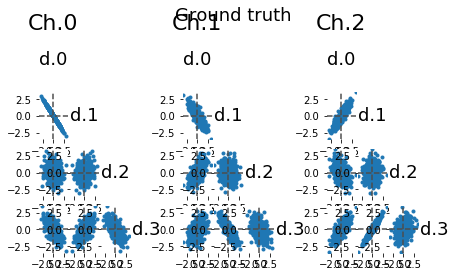

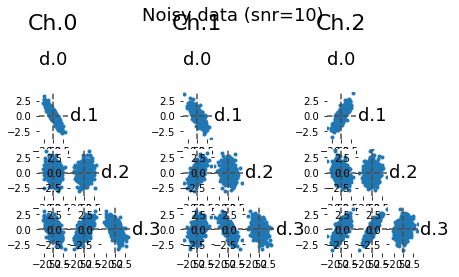

In [10]:
snr=10
x, x_noisy = utilities.preprocess_and_add_noise(x_, snr=snr)

# Send to GPU (if possible)
X = [c.to(DEVICE) for c in x] if torch.cuda.is_available() else x

plot.lsplom(utilities.ltonumpy(x), title=f'Ground truth')
plot.lsplom(utilities.ltonumpy(x_noisy), title=f'Noisy data (snr={snr})')

### Model Fitting
We will fit the noisy data to two multi-channel models: sparse one and non-sparse one.

In [6]:
###################
## Model Fitting ##
###################
init_dict = {
    'n_channels': len(x),
    'lat_dim': fit_lat_dims,
    'n_feats': tuple([i.shape[1] for i in X]),
}

adam_lr = 1e-3
n_epochs = 20000

model = {}

# Multi-Channel VAE
torch.manual_seed(24)
model['mcvae'] = pytorch_modules.MultiChannelBase(
    **init_dict,
    model_name_dict={**init_dict, 'adam_lr': adam_lr, 'snr': snr},
)

# Sparse Multi-Channel VAE
torch.manual_seed(24)
model['smcvae'] = pytorch_modules.MultiChannelSparseVAE(
    **init_dict,
    model_name_dict={**init_dict, 'adam_lr': adam_lr, 'snr': snr},
)

model_dir = Path('MODELS')
if not model_dir.exists():
    model_dir.mkdir()

for current_model in model.keys():

    modelbasename = f'{model_dir}/{model[current_model].model_name}'
    modelpath = f'{modelbasename}.pt'
    
    # If the model is already fitted (and saved) just load it.
    # Otherwise fit it.
    
    if os.path.exists(modelpath):
        print(f"Loading {modelpath}")
        mdict = torch.load(modelpath, map_location=DEVICE)
        model[current_model].load_state_dict(mdict['state_dict'])
        model[current_model].optimizer = torch.optim.Adam(model[current_model].parameters())
        model[current_model].optimizer.load_state_dict(mdict['optimizer'])
        model[current_model].loss = mdict['loss']
        model[current_model].eval()
        del mdict
    else:
        print(f"Fitting {modelpath}")
        model[current_model].init_loss()
        model[current_model].optimizer = torch.optim.Adam(model[current_model].parameters(), lr=adam_lr)
        model[current_model].optimize(epochs=n_epochs, data=X)
        print("Refine optimization...")
        # There is a better way to do this passage by using the pytorch scheduler.
        for pg in model[current_model].optimizer.param_groups:
            pg['lr'] *= 0.1
        model[current_model].optimize(epochs=n_epochs, data=X)
        utilities.save_model(model[current_model])

Loading MODELS/MultiChannelBase__adam_lr_0.001__lat_dim_5__n_channels_3__n_feats_12__snr_10.pt
Loading MODELS/MultiChannelSparseVAE__adam_lr_0.001__lat_dim_5__n_channels_3__n_feats_12__snr_10.pt


### Check the convergence of the loss function
Compare the log-likelihood (ll) between the two models: which one gives the highest one?

What does this mean?

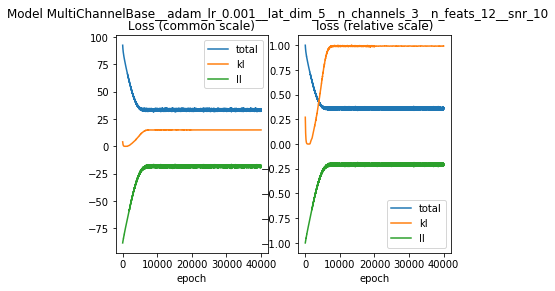

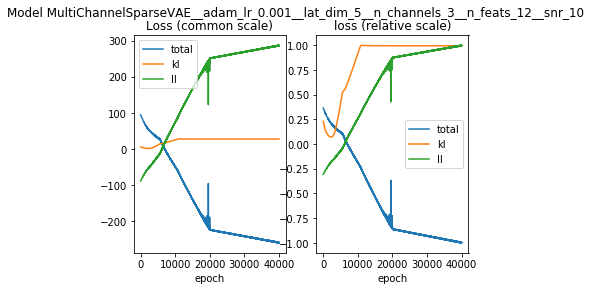

In [9]:
for m in model.keys():
    diagnostics.plot_loss(model[m])

### Data recovery
With our models we fitted a noisy dataset.

Are we able to reconstruct the ground-truth dataset?

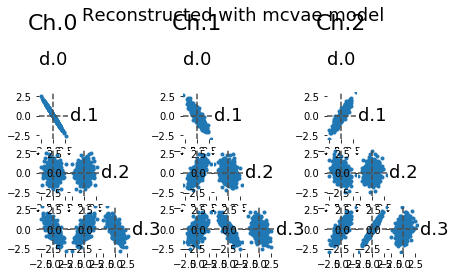

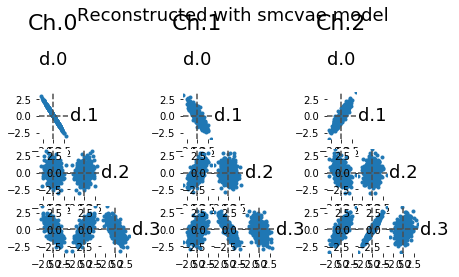

In [10]:
x_hat = {}  # reconstructed channels

for m in model.keys():
    x_hat[m] = model[m].reconstruct(X)
    plot.lsplom(utilities.ltonumpy(x_hat[m]), title=f'Reconstructed with {m} model')

### Sparse vs Non-sparse model
The models are over-parametrized by constructions. In fact, we fitted them with 5 latent dimensions, when the latent dimensions used to generate the dataset are only 2.

With the sparse model the parameters in excess are shutted down, i.e. they are setted to zero.

In the following figures we show that the count of zero-valued parameters is higher in the sparse model.

In [13]:
# Output of the models
pred = {}  # Prediction (return from model.forward() method)
z = {}     # Latent Space
g = {}     # Generative Parameters

for m in model.keys():
    pred[m] = model[m](X)
    z[m] = np.array([pred[m]['qzx'][i].loc.detach().numpy() for i in range(n_channels)]).reshape(-1)
    g[m] = np.array([model[m].W_out[i].weight.detach().numpy() for i in range(n_channels)]).reshape(-1)

Text(0.5,0,'Value')

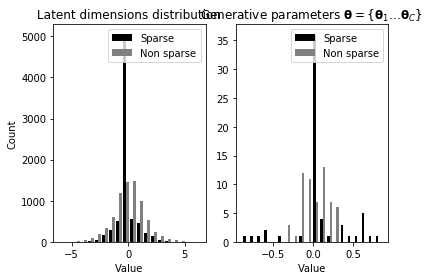

In [14]:
plt.figure()
plt.subplot(1,2,1)
plt.hist([z['smcvae'], z['mcvae']], bins=20, color=['k', 'gray'])
plt.legend(['Sparse', 'Non sparse'])
plt.title(r'Latent dimensions distribution')
plt.ylabel('Count')
plt.xlabel('Value')
plt.subplot(1,2,2)
plt.hist([g['smcvae'], g['mcvae']], bins=20, color=['k', 'gray'])
plt.legend(['Sparse', 'Non sparse'])
plt.title(r'Generative parameters $\mathbf{\theta} = \{\mathbf{\theta}_1 \ldots \mathbf{\theta}_C\}$')
plt.xlabel('Value');

### Dropout
A more interpretable way to show, in the sparse model, how unuseful latent dimensions are shutted down, is to plot the "dropout" probability for each one of them.

A very high dropout probability means that that latent dimension is not useful, hence can be ignored.

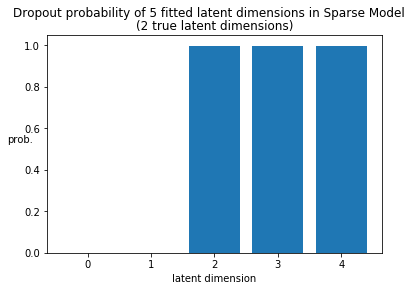

In [18]:
# Show dropout effect
do = np.sort(model['smcvae'].dropout.detach().numpy().reshape(-1))
plt.figure()
plt.bar(range(len(do)), do)
plt.suptitle(f'Dropout probability of {fit_lat_dims} fitted latent dimensions in Sparse Model')
plt.title(f'({true_lat_dims} true latent dimensions)')
plt.xlabel('latent dimension')
plt.ylabel('prob.', rotation=0);